## Lazily loading files
Now we only want to load the files if we're actually going to look at them. This is the same thing that dask does for chunks within a file, but we want the lazy loading to work on the whole file, so that xarray.open_dataset() itself only gets run when we need that file's data.

To do this, we need to create a function using the decorator dask.delayed. This tells Dask that we want to run the function lazily, so it only runs when we need the output. The delayed result then needs to be changed into an array, using the function dask.array.from_delayed(). In addition to the delayed result, we also need to say what the size of the array will be, and what type its values are. Since the delayed function hasn't been run yet Dask has no way of telling this itself.

In [13]:
# https://climate-cms.org/2018/09/14/dask-era-interim.html

import dask
import glob
import xarray as xr
import numpy  as np
import pandas as pd

In [43]:
# Generate filelist
basepath='/gws/nopw/j04/eo_shared_data_vol1/satellite/imerg/Data/'
files=[]
for year in ['2015']:
    files.append(glob.glob(basepath+f'{year}/*/*/*'))
files_rough=files[0]
print('Made file list...')

Made file list...


In [44]:
files_new=[]
for f in files_rough:
    if f.split('/')[11].split('.')[0]=='3B-HHR':
        files_new.append(f)
        
np.shape(files_new)

(17520,)

In [29]:
d0 = xr.open_dataset(files[0], engine='h5netcdf', group='Grid')

time = pd.date_range('2015-01-01 00:00:00', '2015-12-31 23:30:00', freq = '30min')
print(time)

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 00:30:00',
               '2015-01-01 01:00:00', '2015-01-01 01:30:00',
               '2015-01-01 02:00:00', '2015-01-01 02:30:00',
               '2015-01-01 03:00:00', '2015-01-01 03:30:00',
               '2015-01-01 04:00:00', '2015-01-01 04:30:00',
               ...
               '2015-12-31 19:00:00', '2015-12-31 19:30:00',
               '2015-12-31 20:00:00', '2015-12-31 20:30:00',
               '2015-12-31 21:00:00', '2015-12-31 21:30:00',
               '2015-12-31 22:00:00', '2015-12-31 22:30:00',
               '2015-12-31 23:00:00', '2015-12-31 23:30:00'],
              dtype='datetime64[ns]', length=17520, freq='30T')


In [51]:
# This function only gets run when dask needs to look at the result
@dask.delayed
def open_file_delayed(file):
    # I've added a print() here to show when the delayed function gets run
    print(f'open_file_delayed({file})')
    
    # Otherwise it just opens and returns the file as a xarray.Dataset
    return xr.open_dataset(file,
                           engine='h5netcdf', group='Grid',
                           chunks={'time':1, 'lon': 100, 'lat': 100})

def open_file(file):
    # Prepare to open the file
    var_data = open_file_delayed(file)['precipitationCal'].data
    
    # Tell Dask the delayed function returns an array, and the size and type of that array
    return dask.array.from_delayed(var_data,
                                   (1, d0.lon.size, d0.lat.size), 
                                   d0['precipitationCal'].dtype)

In [52]:
# Run open_datefile on each file of the dataset - note that open_datefile_delayed() hasn't yet been run
delayed_precipCal = dask.array.concatenate([open_file(f) for f in files_new], axis=0)
delayed_precipCal

dask.array<concatenate, shape=(17520, 3600, 1800), dtype=float32, chunksize=(1, 3600, 1800), chunktype=numpy.ndarray>

In [53]:
precipCal = xr.DataArray(delayed_precipCal,
                 dims = ['time','lon', 'lat'],
                 coords = {
                     'time': pd.date_range('2015-01-01 00:00:00', '2015-12-31 23:30:00', freq = '30min'),
                     'lon': d0.lon,
                     'lat': d0.lat,
                 },
                name = d0['precipitationCal'].name,
                attrs = d0['precipitationCal'].attrs)
precipCal

<xarray.DataArray 'precipitationCal' (time: 17520, lon: 3600, lat: 1800)>
dask.array<concatenate, shape=(17520, 3600, 1800), dtype=float32, chunksize=(1, 3600, 1800), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 ... 2015-12-31T23:30:00
  * lon      (lon) float32 -179.95 -179.85 -179.75 ... 179.75 179.85 179.95
  * lat      (lat) float32 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
Attributes:
    DimensionNames:    time,lon,lat
    Units:             mm/hr
    units:             mm/hr
    CodeMissingValue:  -9999.9

open_file_delayed(/gws/nopw/j04/eo_shared_data_vol1/satellite/imerg/Data/2015/01/01/3B-HHR.MS.MRG.3IMERG.20150101-S000000-E002959.0000.V06B.HDF5)


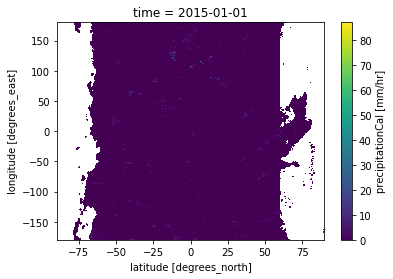

In [55]:
precipCal[0,...].plot()

In [56]:
precipCal.data

dask.array<concatenate, shape=(17520, 3600, 1800), dtype=float32, chunksize=(1, 3600, 1800), chunktype=numpy.ndarray>